CocaCola sales seem to follow a cycle of four quarters (using quarterly data). We model the sales below.

In the linear model of seasonality:

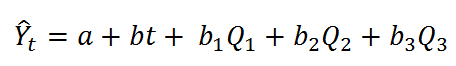

the coefficients of the dummy variables b1, b2 and b3 indicate how much each quarter differs from the reference quarter, quarter4.
The average increase from one quarter to the next is b (the coefficient of t). This is the trend effect.  Quarter 1 averages b1 units higher than the reference quarter, quarter 4, quarter 2 averages b2 units higher than quarter 4, etc. These other coefficients indicate the effect of seasonality. 


In what follows we are implementing a multiplicative seasonal model of seasonality:


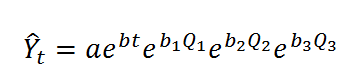

Which after taking logs is:

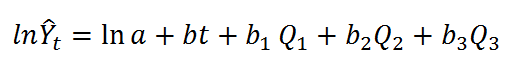

In this multiplicative model the coefficients are percentage changes in the original sales variable Y.  The coefficient of time means that deseasonalized sales increase by b% per quarter. This is the trend effect. The coefficients b1, b2 and b3 mean that the sales in quarters 1, 2 and 3 are respectively b1% above quarter 4, b2% above quarter 4 and b3% above quarter 4. Quarter 4 is the reference quarter.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
#The following function is borrowed from :  Dmitriy Sergeyev, Data Scientist @ Zeptolab, lecturer in the Center of Mathematical Finance in MSU
#https://mlcourse.ai/articles/topic9-part1-time-series/

import statsmodels.api as sm
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries pandas series
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Agumented Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [74]:
def detrendPrice(dft):
    #make sure the input dft has no Nan, otherwise OLS will break
    # fit linear model
    series=dft.Sales
    length = len(series)
    x = np.arange(length)
    y = np.array(series.values)
    x_const = sm.add_constant(x) #need to add intercept constant
    model = sm.OLS(y,x_const)
    results = model.fit()
    predictions = results.predict(x_const)
    resid = y - predictions
    df=pd.DataFrame(resid, columns=['Sales'])
    df.index = dft.index
    return df

In [75]:
def MAD_mean_ratio(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.mean(y_true))) * 100

In [76]:
#The following 2 functions are borrowed from :  Dmitriy Sergeyev, Data Scientist @ Zeptolab, lecturer in the Center of Mathematical Finance in MSU
#https://mlcourse.ai/articles/topic9-part1-time-series/

def plotModelResults(model, X_train, X_test, y_test, plot_intervals=False, test_data=True):
    """
        Plots modelled vs fact values, prediction intervals
    
    """
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)

    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
    error = MAD_mean_ratio(prediction, y_test)
    if (test_data==True):
        plt.title("Test data MAD_mean_ratio error {0:.2f}%".format(error))
    else:
        plt.title("Train data MAD_mean_ratio error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model,X_train):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [77]:
# Read the CSV file, parsing the 'Date' column as datetime
df = pd.read_csv('CocaCola.csv', parse_dates=['Date'], infer_datetime_format=True)

# Convert the 'Date' column to datetime and create a new 'datetime' column
df["datetime"] = pd.to_datetime(df['Date'])

# Set the 'datetime' column as the index of the DataFrame
df.set_index('datetime', inplace=True)

# Drop the original 'Date' column from the DataFrame
df.drop(["Date"], axis=1, inplace=True)

# Display the first few rows of the DataFrame
df.head()

/var/folders/mg/l5f3xml94wjb2ks03kfgl9840000gn/T/ipykernel_73798/1117467164.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('CocaCola.csv', parse_dates=['Date'], infer_datetime_format=True)


,Sales
datetime,
1986-04-01,1734.83
1986-07-01,2244.96
1986-10-01,2533.80
1987-01-01,2154.96
1987-04-01,1547.82


,Sales,quarter
datetime,,
1986-04-01,7.458665,2
1986-07-01,7.716443,3
1986-10-01,7.837475,4
1987-01-01,7.675527,1
1987-04-01,7.344603,2


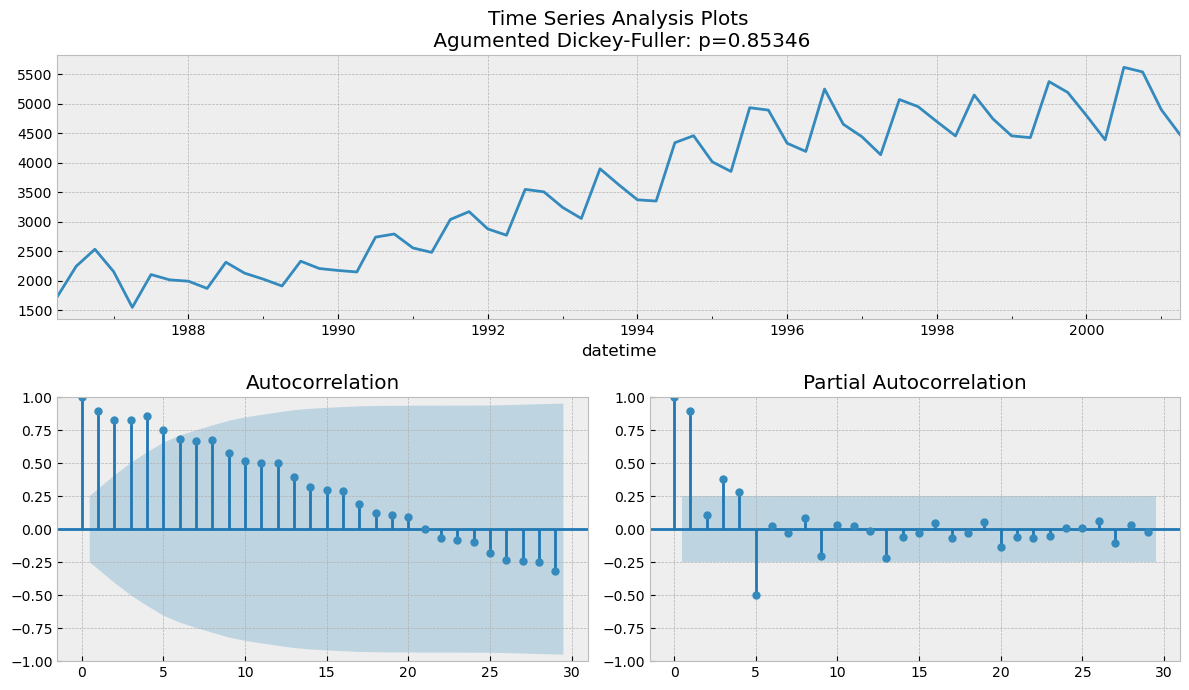

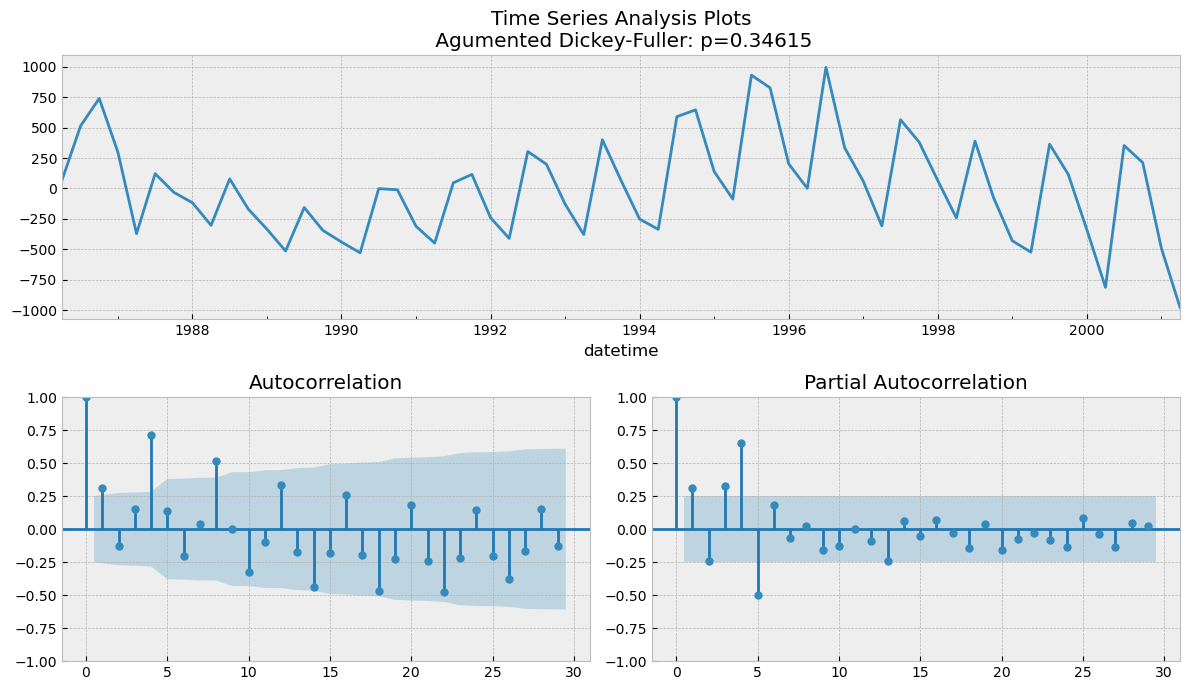

In [78]:
# Plot original Sales data
tsplot(df["Sales"], lags=29)

# Handle missing values
df.dropna(inplace=True)

# Detrend the data
df_detrended = detrendPrice(df)

# Plot detrended data
tsplot(df_detrended["Sales"], lags=29)

# Apply log transformation for multiplicative seasonal model
df["Sales"] = np.log(df["Sales"])

# Generate quarter column
df["quarter"] = df.index.quarter

# Print first few rows
df.head()

In [79]:
# Assuming 'df' is already created and contains a 'quarter' column
df_dummies = pd.get_dummies(df["quarter"], prefix="quarter").astype(int)

# Print first 5 rows
df_dummies.head()

,quarter_1,quarter_2,quarter_3,quarter_4
datetime,,,,
1986-04-01,0,1,0,0
1986-07-01,0,0,1,0
1986-10-01,0,0,0,1
1987-01-01,1,0,0,0
1987-04-01,0,1,0,0


In [80]:
# Join the dummy variables with the original DataFrame
df = df.join(df_dummies)

# Print first few rows
df.head()

,Sales,quarter,quarter_1,quarter_2,quarter_3,quarter_4
datetime,,,,,,
1986-04-01,7.458665,2,0,1,0,0
1986-07-01,7.716443,3,0,0,1,0
1986-10-01,7.837475,4,0,0,0,1
1987-01-01,7.675527,1,1,0,0,0
1987-04-01,7.344603,2,0,1,0,0


In [81]:
# Drop the "quarter" and "quarter_4" columns
df.drop(["quarter", "quarter_4"], inplace=True, axis=1)

# Print the first few rows
df.head()


,Sales,quarter_1,quarter_2,quarter_3
datetime,,,,
1986-04-01,7.458665,0,1,0
1986-07-01,7.716443,0,0,1
1986-10-01,7.837475,0,0,0
1987-01-01,7.675527,1,0,0
1987-04-01,7.344603,0,1,0


In [82]:
# Generate a list of sequential numbers from 0 to df.shape[0] - 1
df["time"] = list(range(0, df.shape[0]))

# Print the first few rows
df.head()


,Sales,quarter_1,quarter_2,quarter_3,time
datetime,,,,,
1986-04-01,7.458665,0,1,0,0
1986-07-01,7.716443,0,0,1,1
1986-10-01,7.837475,0,0,0,2
1987-01-01,7.675527,1,0,0,3
1987-04-01,7.344603,0,1,0,4


In [ ]:
# Extract the target variable
y = df["Sales"]

# Drop 'Sales' from features and save the result as X
df.drop(["Sales"], inplace=True, axis=1)
X = df  # Now X contains only independent variables

# Split data into 80% training and 20% testing sets (without shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Instantiate a Linear Regression model
lr = LinearRegression()

# Fit the model to the training set
lr_fitted = lr.fit(X_train, y_train)

# Predict on the training set (interpolation)
predictions_train = lr_fitted.predict(X_train)

# Predict on the testing set (forecasting)
predictions_test = lr_fitted.predict(X_test)

# Function to calculate MAD/MEAN ratio
def MAD_mean_ratio(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.mean(y_true))) * 100


Train MAD/MEAN Ratio Error: 0.75%
Test MAD/MEAN Ratio Error: 2.51%


In [83]:

# Evaluate on training data
train_error = MAD_mean_ratio(y_train, predictions_train)
print(f"Train MAD/MEAN Ratio Error: {train_error}")

# Evaluate on testing data
test_error = MAD_mean_ratio(y_test, predictions_test)
print(f"Test MAD/MEAN Ratio Error: {test_error}")

Train MAD/MEAN Ratio Error: 0.7513756334676818
Test MAD/MEAN Ratio Error: 2.5127729607789804


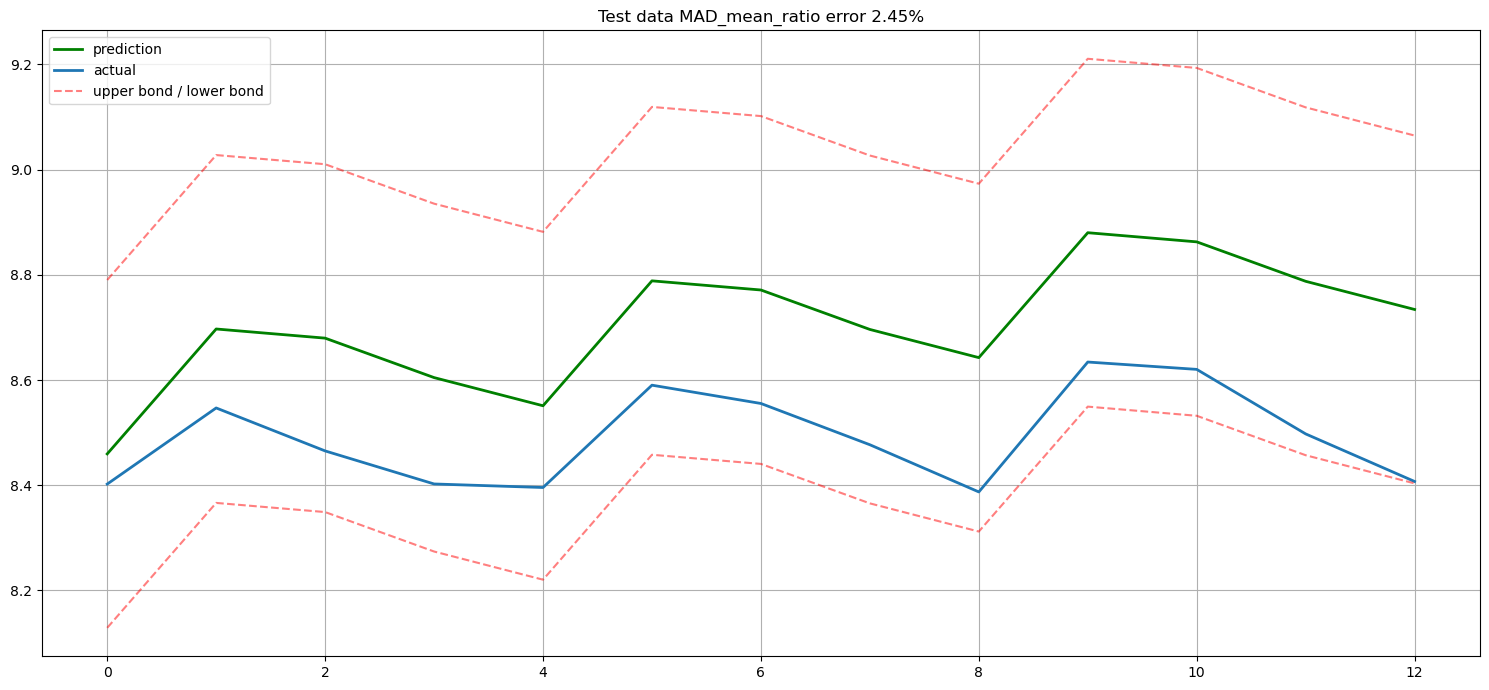

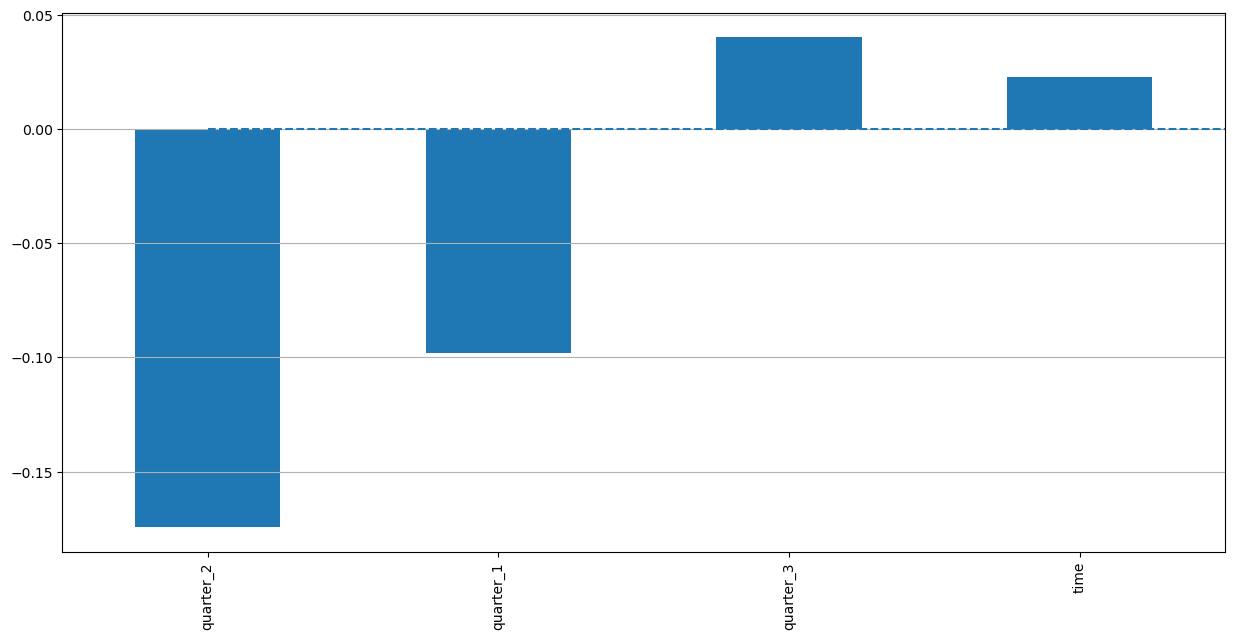

In [84]:
# Plot Model Results on Test Data
plotModelResults(lr_fitted, X_train, X_test, y_test, plot_intervals=True, test_data=True)

# Plot Feature Importance
plotCoefficients(lr_fitted, X_train)

Original Data:
              Sales  quarter_1  quarter_2  quarter_3  time
datetime                                                  
1986-04-01  1734.83          0          1          0     0
1986-07-01  2244.96          0          0          1     1
1986-10-01  2533.80          0          0          0     2
1987-01-01  2154.96          1          0          0     3
1987-04-01  1547.82          0          1          0     4
Best alpha found: 6.158482110660261
Train MAD/MEAN Ratio Error (Method A): 0.85%
Test MAD/MEAN Ratio Error (Method A): 5.60%
Train MAD/MEAN Ratio Error (Method B): 0.85%
Test MAD/MEAN Ratio Error (Method B): 1.59%


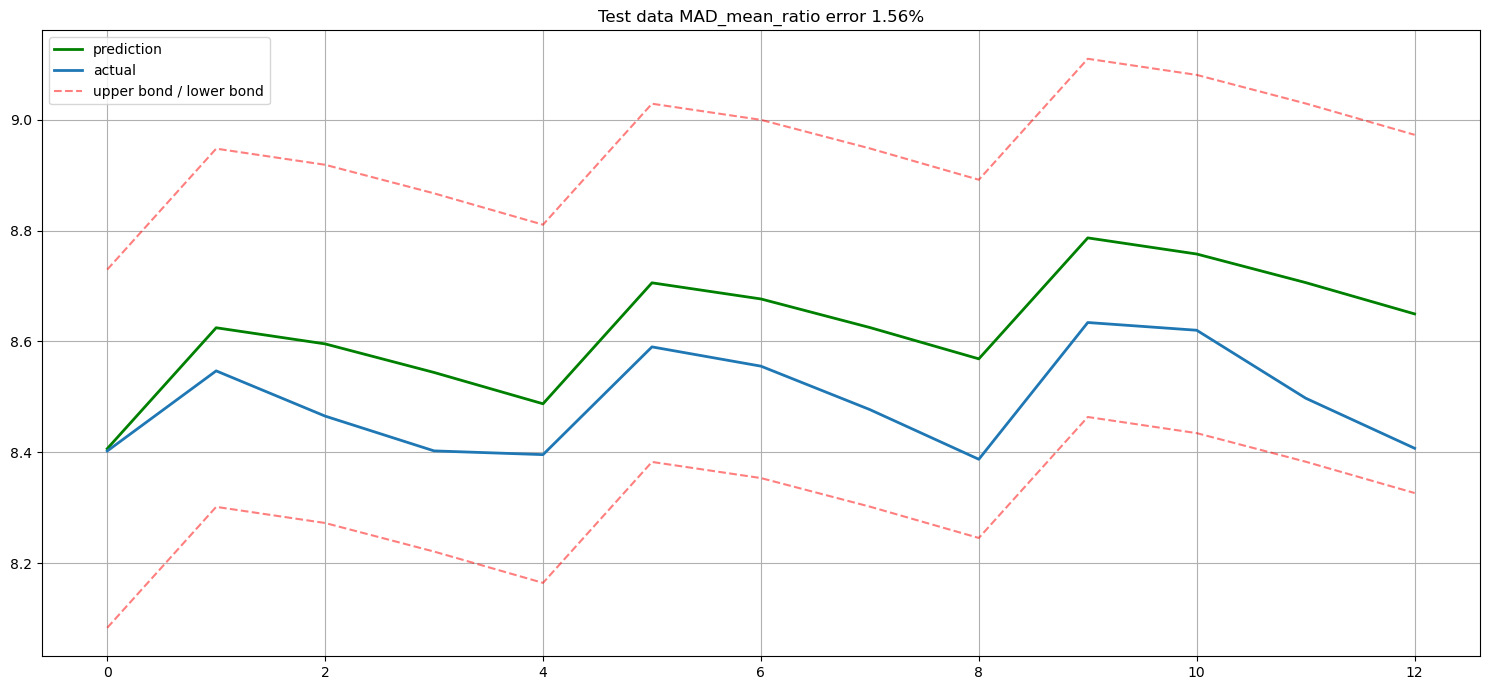

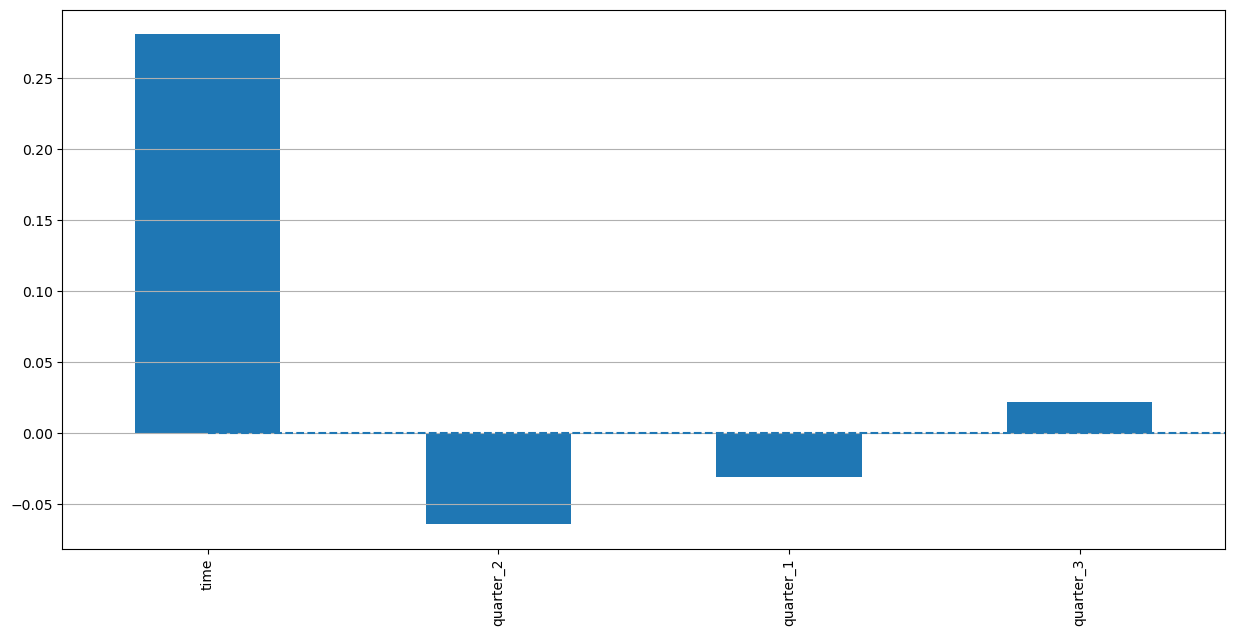

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

# 1️⃣ Load and visualize unscaled data
print("Original Data:")
print(df.head())

# 2️⃣ Split into train (80%) and test (20%) without shuffling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# 3️⃣ Set up a pipeline with StandardScaler and Ridge regression
pipe = Pipeline([
    ("scaler", StandardScaler()), 
    ("ridge", Ridge())  # Ridge Regression Model
])

# 4️⃣ Set up TimeSeriesSplit (5 folds)
tscv = TimeSeriesSplit(n_splits=5)

# 5️⃣ Define the grid of hyperparameters to tune
param_grid = {"ridge__alpha": np.logspace(-3, 3, 20)}  # Testing alpha from 0.001 to 1000

# 6️⃣ Perform Grid Search with cross-validation
grid_search = GridSearchCV(pipe, param_grid, cv=tscv, scoring="neg_mean_absolute_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best alpha value
best_alpha = grid_search.best_params_["ridge__alpha"]
print(f"Best alpha found: {best_alpha}")

# **Option A: Train a new Ridge model with optimized alpha**
ridge_best_A = Ridge(alpha=best_alpha)
ridge_best_A.fit(StandardScaler().fit_transform(X_train), y_train)

# **Option B: Get the best model directly from grid search**
ridge_best_B = grid_search.best_estimator_[1]  # Ridge model from pipeline

# 7️⃣ Predict on training and testing data using both approaches
predictions_train_A = ridge_best_A.predict(StandardScaler().fit_transform(X_train))
predictions_test_A = ridge_best_A.predict(StandardScaler().fit_transform(X_test))

predictions_train_B = grid_search.predict(X_train)  # No need to scale X_train here
predictions_test_B = grid_search.predict(X_test)  # No need to scale X_test here

# 8️⃣ Evaluate the model using MAD/MEAN Ratio
train_error_A = MAD_mean_ratio(y_train, predictions_train_A)
test_error_A = MAD_mean_ratio(y_test, predictions_test_A)

train_error_B = MAD_mean_ratio(y_train, predictions_train_B)
test_error_B = MAD_mean_ratio(y_test, predictions_test_B)

print(f"Train MAD/MEAN Ratio Error (Method A): {train_error_A:.2f}%")
print(f"Test MAD/MEAN Ratio Error (Method A): {test_error_A:.2f}%")

print(f"Train MAD/MEAN Ratio Error (Method B): {train_error_B:.2f}%")
print(f"Test MAD/MEAN Ratio Error (Method B): {test_error_B:.2f}%")

# 9️⃣ Plot Predictions vs. Actual Values (Choose best method based on graph similarity)
plotModelResults(grid_search, X_train, X_test, y_test, plot_intervals=True, test_data=True)

# 🔟 Plot Feature Importance (Ridge Regression Coefficients)
plotCoefficients(ridge_best_A, X_train)


In [86]:
def LambdaMax(X, Y, model_type): 
    from sklearn.linear_model import Ridge
    from sklearn.linear_model import Lasso
    from sklearn.linear_model import LogisticRegression
    
    if not isinstance(Y, np.ndarray):
         Y = Y.values #for logistic Y values should be categorical
    if not isinstance(X, np.ndarray):
        X = X.values #X values should be scaled
        
    n = X.shape[0]
   
    if model_type=="lasso":
        # Calculate LambdaMax for lasso-like regularization
        LambdaMax_lasso = np.max(np.abs(X.T @ Y))

        print("LambdaMax (for Lasso):", LambdaMax_lasso)
        model = Lasso(alpha=LambdaMax_lasso)
        model.fit(X,Y)
        print("lasso coefs", model.coef_ )#coefs should be close to zero
    
    if model_type == "ridge":
        # Calculate LambdaMax for ridge-like regularization
        LambdaMax_ridge = 2 * np.max(np.abs(X.T @ Y)) / n

        print("LambdaMax (for Ridge):", LambdaMax_ridge)
        model = Ridge(alpha=LambdaMax_ridge)
        model.fit(X,Y)
        print("ridge coefs", model.coef_ )#coefs should be close to zero

    if model_type == "logistic":
        # Fit logistic regression model without regularization (high C value means less regularization)
        model = LogisticRegression(penalty='l2', C=1e10, solver='liblinear')
        model.fit(X, Y)

        # Calculate the gradient of the loss function at the fitted coefficients
        # Logistic loss gradient w.r.t. coefficients: X.T * (Y - p)
        p = model.predict_proba(X)[:, 1]  # model predictions as probabilities
        gradients = np.dot(X.T, (Y - p))  # gradients of the loss function

        # Calculate LambdaMax_logistic for L2 Logistic Regression
        LambdaMax_logistic = np.max(np.abs(gradients))
 
        print("LambdaMax (for Logistic):", LambdaMax_logistic)
        print("C (for Logistic):", 1/LambdaMax_logistic)  
        model =  LogisticRegression(C=1/LambdaMax_logistic) #C = 1/LambdaMax_logistic
        model.fit(X,Y)
        print("logistic coefs",model.coef_ )#coefs should be close to zero

In [87]:
LambdaMax(X_train, y_train, "ridge")

LambdaMax (for Ridge): 385.5511942335476
ridge coefs [-0.0011816  -0.00356179  0.00294035  0.02207759]


In [88]:

# Start value
start = 385.5511942335476 #Obtained from LambdaMax
# End value
stop = 0.1
# Number of points
num_points = 50

# Generate evenly spaced values
evenly_spaced_values = np.linspace(start, stop, num_points)
param_grid = [{'ridge__alpha':evenly_spaced_values}]


Best alpha found: 7.96635090272548
Train MAD/MEAN Ratio Error (Ridge, Refined Alpha): 0.91%
Test MAD/MEAN Ratio Error (Ridge, Refined Alpha): 5.60%


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


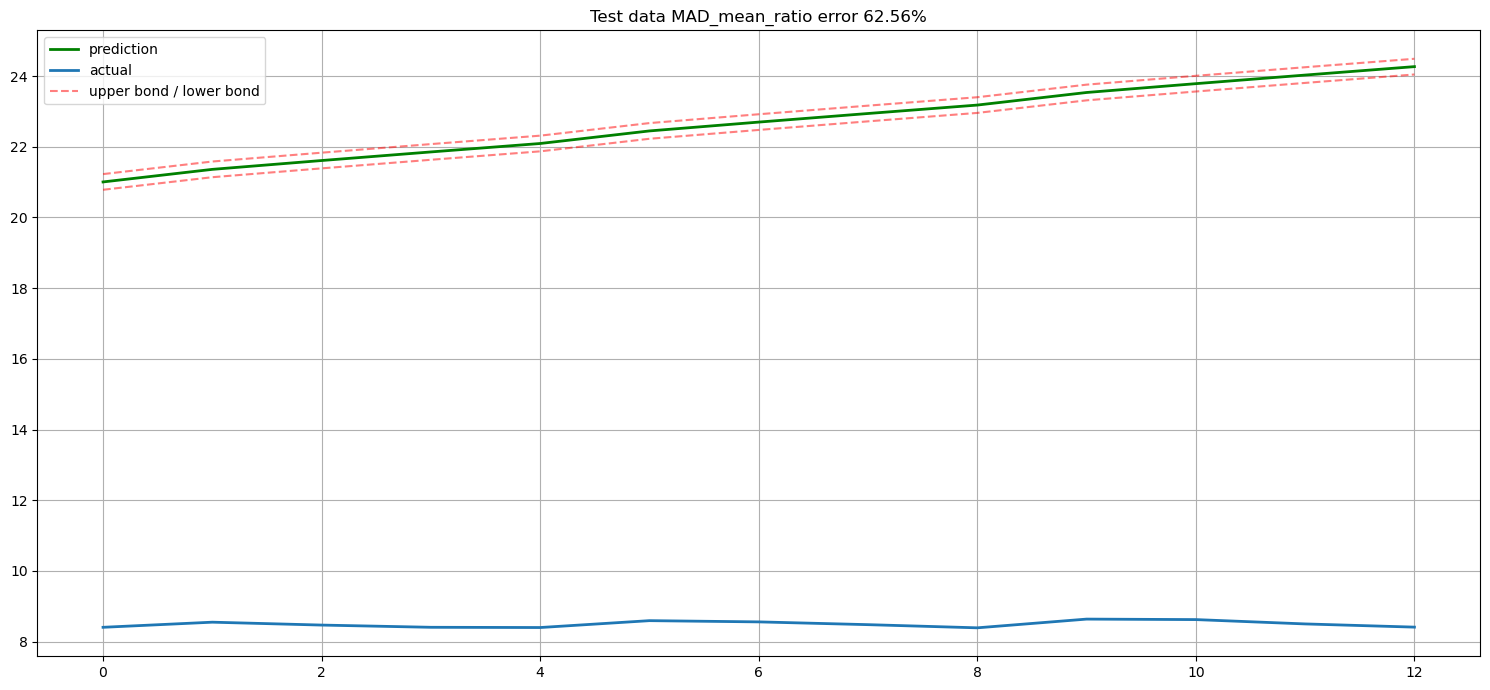

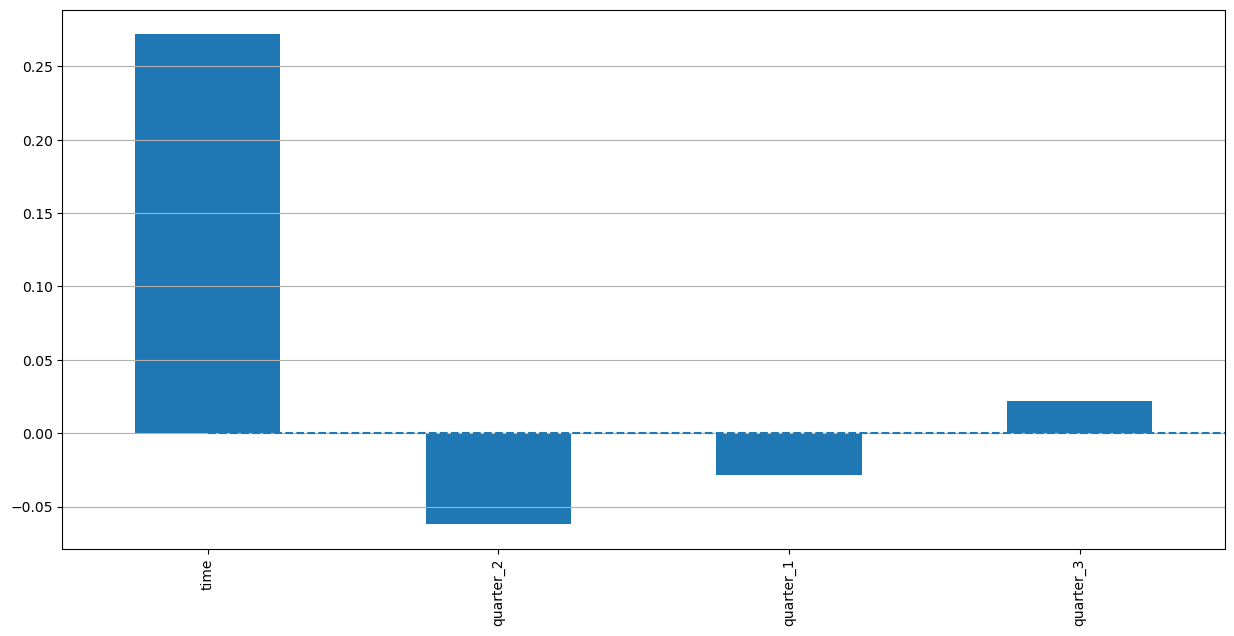

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

# 1️⃣ Define the refined search space for ridge__alpha
start = 385.5511942335476  # LambdaMax obtained from previous calculation
stop = 0.1
num_points = 50

# Generate evenly spaced values for alpha search space
evenly_spaced_values = np.linspace(start, stop, num_points)
param_grid = [{"ridge__alpha": evenly_spaced_values}]

# 2️⃣ Set up a pipeline with StandardScaler and Ridge Regression
pipe = Pipeline([
    ("scaler", StandardScaler()), 
    ("ridge", Ridge())  # Ridge Regression Model
])

# 3️⃣ Perform Grid Search with TimeSeriesSplit (5 folds)
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(pipe, param_grid, cv=tscv, scoring="neg_mean_absolute_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

# 4️⃣ Get the best alpha and retrain Ridge model
best_alpha = grid_search.best_params_["ridge__alpha"]
print(f"Best alpha found: {best_alpha}")

ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(StandardScaler().fit_transform(X_train), y_train)

# 5️⃣ Predict on training and testing data
predictions_train_ridge = ridge_best.predict(StandardScaler().fit_transform(X_train))
predictions_test_ridge = ridge_best.predict(StandardScaler().fit_transform(X_test))

# 6️⃣ Evaluate the model using MAD/MEAN Ratio
train_error_ridge = MAD_mean_ratio(y_train, predictions_train_ridge)
test_error_ridge = MAD_mean_ratio(y_test, predictions_test_ridge)

print(f"Train MAD/MEAN Ratio Error (Ridge, Refined Alpha): {train_error_ridge:.2f}%")
print(f"Test MAD/MEAN Ratio Error (Ridge, Refined Alpha): {test_error_ridge:.2f}%")

# 7️⃣ Plot Predictions vs. Actual Values
plotModelResults(ridge_best, X_train, X_test, y_test, plot_intervals=True, test_data=True)

# 8️⃣ Plot Feature Importance (Ridge Regression Coefficients)
plotCoefficients(ridge_best, X_train)
